# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
- convert the tracksters into some latent space and predict a link between them

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from reco.training import precision_recall_curve, roc_auc

from torch.utils.data import random_split, DataLoader
from reco.loss import QualityFocalLoss

from reco.datasetPU import TracksterPairs


ds_name = "MultiParticle"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

# writer = SummaryWriter()

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    radius=30,
    bigT_e_th=10,
)

ds.x.shape

torch.Size([2523941, 63])

In [5]:
print(ds.x.shape)
print("Positive:", int((ds.y >= 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.5).type(torch.int).sum()))

torch.Size([2523941, 63])
Positive: 463040
Negative: 2060901


In [6]:
balance =  float(sum(ds.y > 0.5) / len(ds.y))
print("dataset balance:", balance) 

dataset balance: 0.1834591180086136


In [7]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set, rest = random_split(ds, [1000000, 20000, ds_size - 1020000])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 1000000, Test samples: 20000


In [8]:
loss_obj = QualityFocalLoss(gamma=2)

def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == (labels > 0.5).type(torch.int))
    return (correct / total)

In [9]:
hdim1 = 256
hdim2 = 128

model = nn.Sequential(
    nn.LayerNorm(ds.x.shape[1]),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.Sigmoid(),
    nn.Linear(hdim1, hdim2),
    nn.Sigmoid(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
).to(device)

epochs = 50
model_path = f"models/PairWiseMLP.QFL.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}r.{ds.bigT_e_th}eth.{ds.N_FILES}f.pt"

In [10]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


In [11]:
#%%script echo skipping
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)
loss_obj = QualityFocalLoss(gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, test auc: {test_auc:.4f}')

Epoch: 0, loss: 1092.4716, train auc: 0.9115, test auc: 0.9126
Epoch: 5, loss: 1031.3953, train auc: 0.9164, test auc: 0.9176
Epoch: 10, loss: 1029.5062, train auc: 0.9175, test auc: 0.9188
Epoch: 15, loss: 1025.7295, train auc: 0.9192, test auc: 0.9194
Epoch: 20, loss: 1023.4865, train auc: 0.9183, test auc: 0.9200
Epoch: 25, loss: 1014.2938, train auc: 0.9187, test auc: 0.9201
Epoch: 30, loss: 1006.3120, train auc: 0.9206, test auc: 0.9222
Epoch: 35, loss: 999.7037, train auc: 0.9220, test auc: 0.9238
Epoch: 40, loss: 993.9626, train auc: 0.9231, test auc: 0.9240
Epoch: 45, loss: 988.1557, train auc: 0.9234, test auc: 0.9246


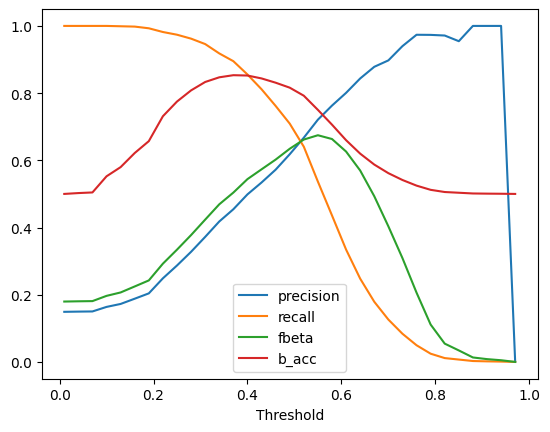

TP: 1600, TN: 16399, FP: 619, FN: 1382
TH: 0.55 precision: 0.721 recall: 0.537 fbeta: 0.675 b_acc: 0.750


In [12]:
#%%script echo skipping
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3)

In [13]:
#%%script echo skipping
torch.save(model.state_dict(), model_path)
del ds

# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [3]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15163313_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [14]:
r_ranges = range(5, 45, 5)
results = []

clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []

max_events = 20

for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        reco_to_target=False,
        bigT_e_th=10,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    naive_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        reco_to_target=False,
        bigT_e_th=10,
    )
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.991 R: 0.148 F: 0.464
	target_to_sim:	P: 0.990 R: 0.151 F: 0.469
	reco_to_sim:	P: 0.987 R: 0.162 F: 0.488
Event 1:
	clue3d_to_sim:	P: 0.956 R: 0.093 F: 0.335
	target_to_sim:	P: 0.953 R: 0.148 F: 0.456
	reco_to_sim:	P: 0.944 R: 0.156 F: 0.469
Event 2:
	clue3d_to_sim:	P: 0.991 R: 0.189 F: 0.536
	target_to_sim:	P: 0.991 R: 0.201 F: 0.555
	reco_to_sim:	P: 0.980 R: 0.210 F: 0.565
Event 3:
	clue3d_to_sim:	P: 0.975 R: 0.177 F: 0.513
	target_to_sim:	P: 0.973 R: 0.236 F: 0.599
	reco_to_sim:	P: 0.929 R: 0.272 F: 0.626
Event 4:
	clue3d_to_sim:	P: 0.963 R: 0.095 F: 0.340
	target_to_sim:	P: 0.960 R: 0.144 F: 0.450
	reco_to_sim:	P: 0.885 R: 0.153 F: 0.453
Event 5:
	clue3d_to_sim:	P: 0.979 R: 0.136 F: 0.437
	target_to_sim:	P: 0.978 R: 0.159 F: 0.482
	reco_to_sim:	P: 0.978 R: 0.159 F: 0.482
Event 6:
	clue3d_to_sim:	P: 0.982 R: 0.199 F: 0.550
	target_to_sim:	P: 0.981 R: 0.242 F: 0.608
	reco_to_sim:	P: 0.961 R: 0.266 F: 0.631
Event 7:
	clue3d_to

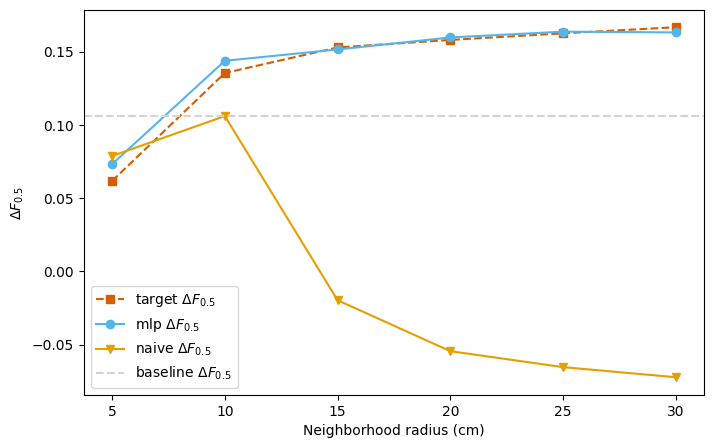

In [16]:
fig = plt.figure(figsize=(8, 5))

r_ranges = range(5, 45, 5)


ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="mlp $\Delta F_{0.5}$", c="#56B4E9")
ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline $\Delta F_{0.5}$", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")

fig.savefig('export/multiparticle-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [63]:
max(np.array(model_reco_F) - np.array(clue3D_F))

0.1509655718463616

### Energy threshold identification

In [6]:
eth_ranges = [0, 5, 10, 20, 40, 60]
r_ranges = range(10, 40, 10)
eth_results = []

max_events = 10

for r in r_ranges:
    _clue3D_F = []
    _target_F = []
    for eth in eth_ranges:
        print(f" --- Radius threshold: {r} | ETH: {eth} ---")
        result = model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=r,
            max_events=max_events,
            bigT_e_th=eth,
            reco_eval=False
        )
        _clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
        _target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    eth_results.append(np.array(_target_F) - np.array(_clue3D_F))

 --- Radius threshold: 10 | ETH: 0 ---
Event 0:
	clue3d_to_sim:	P: 0.991 R: 0.148 F: 0.464
	target_to_sim:	P: 0.988 R: 0.170 F: 0.504
Event 1:
	clue3d_to_sim:	P: 0.956 R: 0.093 F: 0.335
	target_to_sim:	P: 0.951 R: 0.192 F: 0.531
Event 2:
	clue3d_to_sim:	P: 0.991 R: 0.189 F: 0.536
	target_to_sim:	P: 0.986 R: 0.296 F: 0.672
Event 3:
	clue3d_to_sim:	P: 0.975 R: 0.177 F: 0.513
	target_to_sim:	P: 0.970 R: 0.296 F: 0.667
Event 4:
	clue3d_to_sim:	P: 0.963 R: 0.095 F: 0.340
	target_to_sim:	P: 0.956 R: 0.204 F: 0.551
Event 5:
	clue3d_to_sim:	P: 0.979 R: 0.136 F: 0.437
	target_to_sim:	P: 0.975 R: 0.199 F: 0.548
Event 6:
	clue3d_to_sim:	P: 0.982 R: 0.199 F: 0.550
	target_to_sim:	P: 0.979 R: 0.321 F: 0.695
Event 7:
	clue3d_to_sim:	P: 0.990 R: 0.171 F: 0.505
	target_to_sim:	P: 0.986 R: 0.207 F: 0.563
Event 8:
	clue3d_to_sim:	P: 0.984 R: 0.121 F: 0.405
	target_to_sim:	P: 0.982 R: 0.238 F: 0.604
Event 9:
	clue3d_to_sim:	P: 0.986 R: 0.195 F: 0.544
	target_to_sim:	P: 0.982 R: 0.269 F: 0.642
-----
mean 

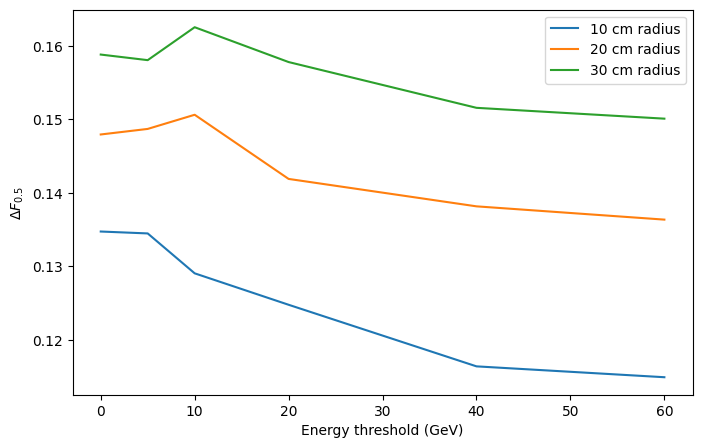

In [7]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

for r, res in zip(r_ranges, eth_results):
    ax.plot(eth_ranges, res, label=f"{r} cm radius")

ax.legend()
# ax.set_xlim(0, 100)
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("$\Delta F_{0.5}$")

fig.savefig('export/multiparticle-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()